
# Local network

- self-supervised learning on MNIST

- Apply feedback alignment to both layers in the PV class (fc1 and fc2), not just the second one (fc2)? 


In [51]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Dataset

In [53]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [54]:
from modules.network import LocalNetwork
# from skimage.metrics import structural_similarity as ssim
import numpy as np

lr = 0.001

model = LocalNetwork(input_dim=784, latent_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

print(model)

LocalNetwork(
  (PV): PV(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=784, bias=True)
    (activation): Sigmoid()
    (fc2): Linear(in_features=784, out_features=128, bias=True)
  )
  (Pyr): Pyr(
    (flatten): Flatten()
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (activation): Sigmoid()
  )
  (Decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=784, bias=True)
  )
)


# Losses: 
- **total_loss** = *lambdaP* * **predict_loss** + **recon_loss**

- **predict_loss**: self-supervised cost of comparison of PV predictions given input; with Pyr input. PV_Pyr_loss. 
- **ssl_loss** = **predict_loss** = 1/2 (Pyr_out-PV_pred)^2
- **recon_loss** : encourages the model to learn non-trivial representations. Pyr_loss. Used to update Pyr fc1 (input to pyr layer) & decoder weights.
- **recon_loss** = 1/2 (recon-input)^2

# Updating weights:
- ∆ (PV fc2 layer) (i.e PV_Pyr) = lr * grad(total_loss) on (PV fc2 layer) = lr * (Pyr_out -PV_pred)PV_out

- ∆ (PV fc1 layer) = lr * grad(total_loss) on (PV fc1 layer) = lr * grad(total_loss) on (PV_out) * grad(PV_out) on (PV fc1 layer)
- ∆ (Pyr fc1 layer) = lr * grad(total_loss) on (Pyr_out) * grad(Pyr_out) on (Pyr fc1 layer) = lr * (Pyr_out - PV_pred) * input
- Decoder uses recon_loss
- +/- Pyr fc1 uses recon_loss ? 
- Since no L4 equivalent: no need feedback alignement? 




### Training & testing

In [60]:
num_epochs = 30
log_interval = 300

train_losses = []
train_pred_losses = []
train_recon_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]

def train(epoch, dataloader):
    pred_loss_avg = 0
    recon_loss_avg = 0
    loss_avg = 0
    model.train()
    pred_coeff = 1. 
    for batch_idx, batch in enumerate(dataloader):
        inputs, _ = batch  
        optimizer.zero_grad()
        PV_out, PV_pred, Pyr_out, recon = model(inputs, inputs)  # same inputs for both PV and pyramidal cells

        inputs = inputs.view(-1, 784)
        pred_loss = criterion(Pyr_out, PV_pred)
        recon_loss = criterion(recon, inputs)
        loss = pred_coeff * pred_loss + recon_loss

        #ssim_score = calculate_ssim(recon, inputs) # Structural Similarity Index (SSIM): luminance, contrast, structure
        loss.backward()
        optimizer.step()
        pred_loss_avg += pred_loss.item()
        recon_loss_avg += recon_loss.item()
        loss_avg += loss.item()

        if batch_idx % log_interval == 0:
            train_losses.append(loss.item())
            train_pred_losses.append(pred_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    pred_loss_avg /= len(dataloader)
    recon_loss_avg /= len(dataloader)
    loss_avg /= len(dataloader)
    print('Epoch: {} Pred_loss: {:.6f}  Recon_loss: {:.6f} Total loss: {:.6f}'.format(epoch, pred_loss_avg, recon_loss_avg, loss_avg))

def test(dataloader):
    model.eval()
    pred_loss_avg = 0
    recon_loss_avg = 0
    test_loss_avg = 0
    pred_coeff = 1.
    with torch.no_grad():
        for batch in dataloader:
            inputs, _ = batch
            PV_out, PV_pred, Pyr_out, recon  = model(inputs, inputs)
            inputs = inputs.view(-1, 784)

            pred_loss = criterion(Pyr_out, PV_pred).item()
            recon_loss = criterion(recon, inputs).item()
            pred_loss_avg += pred_loss
            recon_loss_avg += recon_loss
            test_loss_avg += pred_coeff * pred_loss + recon_loss
            #ssim_score = calculate_ssim(recon, inputs)
    recon_loss_avg /= len(dataloader)        
    pred_loss_avg /= len(dataloader)
    test_loss_avg /= len(dataloader)
    test_losses.append(test_loss_avg)
    print('Test set: Pred_loss: {:.6f}  Recon_loss: {:.6f} Total loss: {:.6f}\n'.format(pred_loss_avg, recon_loss_avg, test_loss_avg))
    

def calculate_ssim(recon, original):
    pass
    recon = recon.detach().cpu().numpy().reshape(-1, 28, 28)
    original = original.detach().cpu().numpy().reshape(-1, 28, 28)
    #ssim_scores = [ssim(r, o, data_range=1) for r, o in zip(recon, original)]
    #return np.mean(ssim_scores)


### In practice

In [61]:
test(test_data_loader)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader)
  test(test_data_loader)

Test set: Avg. loss: 0.0858  Pred_loss: 0.004065  Recon_loss: 0.081714

Epoch: 1 Pred_loss: 0.003613  Recon_loss: 0.075761 Total loss: 0.079374
Test set: Avg. loss: 0.0714  Pred_loss: 0.003152  Recon_loss: 0.068259

Epoch: 2 Pred_loss: 0.002630  Recon_loss: 0.065628 Total loss: 0.068258
Test set: Avg. loss: 0.0642  Pred_loss: 0.002464  Recon_loss: 0.061735

Epoch: 3 Pred_loss: 0.002069  Recon_loss: 0.060438 Total loss: 0.062507
Test set: Avg. loss: 0.0598  Pred_loss: 0.002001  Recon_loss: 0.057749

Epoch: 4 Pred_loss: 0.001668  Recon_loss: 0.057559 Total loss: 0.059227
Test set: Avg. loss: 0.0575  Pred_loss: 0.001690  Recon_loss: 0.055770

Epoch: 5 Pred_loss: 0.001417  Recon_loss: 0.055824 Total loss: 0.057241
Test set: Avg. loss: 0.0564  Pred_loss: 0.001449  Recon_loss: 0.054915

Epoch: 6 Pred_loss: 0.001231  Recon_loss: 0.054652 Total loss: 0.055883
Test set: Avg. loss: 0.0550  Pred_loss: 0.001335  Recon_loss: 0.053674

Epoch: 7 Pred_loss: 0.001087  Recon_loss: 0.053779 Total loss: 0

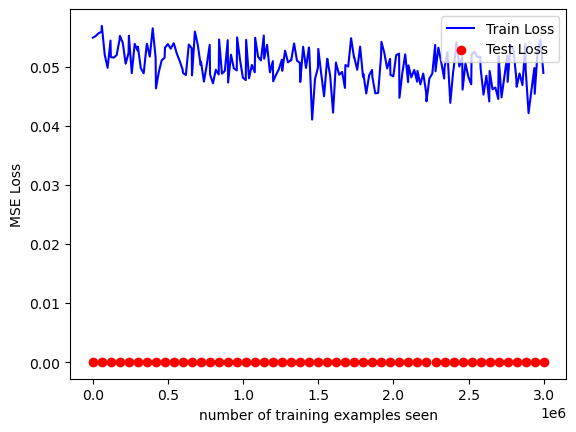

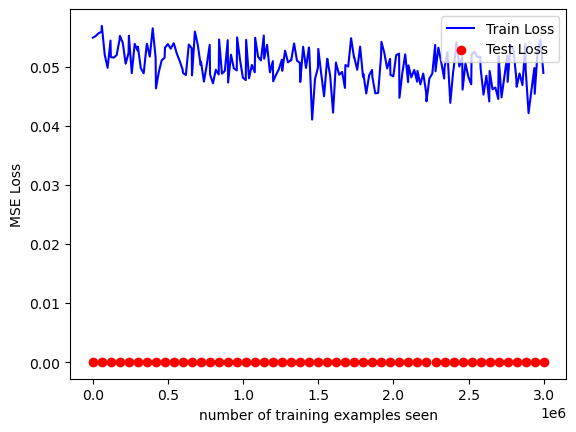

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green')
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_pred_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Total', 'Train Recon', 'Train Pred', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylabel('MSE Loss')
plt.title("Losses across learning")
fig